In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from datasets.lineage_tracing import *

from utils import ksg

In [2]:
# data_dir = '/orcd/data/omarabu/001/gokul/DistributionEmbeddings/data'

# GetLTSeqData(data_dir)

In [2]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfg = [c for c in configs if 'lineage' in c['name']]

In [3]:

print('encoder 0: ', cfg[0]['encoder'])
print('encoder 1: ', cfg[1]['generator'])

encoder 0:  DistributionEncoderGNN
encoder 1:  WormholeGenerator


In [4]:
# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

In [5]:
lts = LTSeqDataset()
print('dataset loaded')
lts.data = lts.data.to('cuda')

dataset loaded


In [6]:
cfg_idxs = [1, 0] 

for c in cfg_idxs:
    print('cfg %d: %s' %(c, cfg[c]['encoder']))
all_pmis = []

for idx in cfg_idxs:
    enc, gen = load_model(cfg[idx]['config'], cfg[idx]['dir'], 'cuda')

    with torch.no_grad():
        z = enc(lts.data)

    emb = pd.DataFrame(z.squeeze(1).cpu().numpy())
    emb['time'] = [m[1] for m in lts.metadata]
    emb['clone'] = [m[0] for m in lts.metadata]
    emb['rep'] = [m[2] for m in lts.metadata]

    N = z.shape[1]
    early = emb[emb['time'].isin(['2.0','4.0'])]
    late = emb[emb['time'] == '6.0']
    common = set(early['clone']).intersection(set(late['clone']))
    print(f'cfg {idx}: {len(common)} common clones')

    t1 = early[early['clone'].isin(common)].groupby('clone', as_index=False)[np.arange(N)].mean()
    t2 = late[late['clone'].isin(common)].groupby('clone', as_index=False)[np.arange(N)].mean()
    pmi_vals = ksg.mi(t2[np.arange(N)], t1[np.arange(N)])

    df = pd.DataFrame({'clone': t1['clone'], f'pmi_cfg{idx}': pmi_vals})
    all_pmis.append(df)

# merge on clone :)
pmi_df = all_pmis[0]
for df in all_pmis[1:]:
    pmi_df = pmi_df.merge(df, on='clone')

print(pmi_df.head())

cfg 1: WormholeEncoder
cfg 0: DistributionEncoderGNN
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
cfg 1: 1188 common clones
cfg 0: 1188 common clones
  clone  pmi_cfg1  pmi_cfg0
0     1  2.306954  7.030957
1    10  0.495253  4.145080
2  1004  3.363396  5.778367
3  1015  1.580886  1.972554
4  1029  0.098261  1.961181


In [7]:
pmi_df['delta'] = pmi_df['pmi_cfg0'] - pmi_df['pmi_cfg1']
top_diffs = pmi_df.sort_values(by='delta').tail(10)
top_diffs

,clone,pmi_cfg1,pmi_cfg0,delta
19,1110,0.183153,6.824858,6.641704
619,366,-1.773512,4.873972,6.647484
626,3702,-2.151670,4.507906,6.659576
330,244,0.156232,6.965120,6.808887
235,2057,-0.925113,5.995308,6.920421
699,4000,-2.798235,4.265775,7.064011
14,1085,-2.638575,4.507906,7.146481
242,2091,-0.332603,7.030957,7.363560
850,4691,-2.589886,5.242661,7.832547
893,490,-2.957223,4.992812,7.950035


/tmp/ipykernel_2030495/1015217686.py:5: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  'time' : [['early', 'late'][a > 4] for a in ad.obs['time'].values]


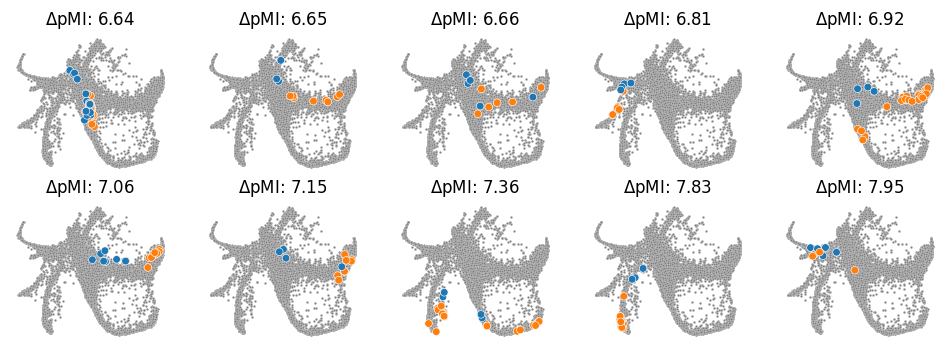

In [8]:
ad = lts.adata
cells = pd.DataFrame({'clone' : ad.obs['clone'].values.astype(int),
     'SPRING1' : ad.obs['SPRING1'].values,
     'SPRING2' : ad.obs['SPRING2'].values,
     'time' : [['early', 'late'][a > 4] for a in ad.obs['time'].values]
})

background = cells.sample(frac=0.2)


fig, axs = plt.subplots(2, 5, dpi=100, figsize=(12, 4))

for c in range(len(top_diffs.values)):
    clone = top_diffs['clone'].values[c]
    ax = axs.flat[c]

    sns.scatterplot(background, x='SPRING1', y='SPRING2', s=3, color='grey', ax=ax)
    sns.scatterplot(cells[cells['clone'] == int(clone)],
                    x='SPRING1', y='SPRING2', s=30, hue='time', 
                    hue_order=['early', 'late'], legend=False,
                    palette='tab10', ax=ax)
    
    ax.axis('off')
    ax.set_title(r"$\Delta$pMI: %.2f"%(top_diffs['delta'].values[c]))
plt.show()


In [9]:
pmi_df['clone'] = pmi_df['clone'].astype(int)
cells = cells.merge(pmi_df, on='clone')

/tmp/ipykernel_2030495/1222531094.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


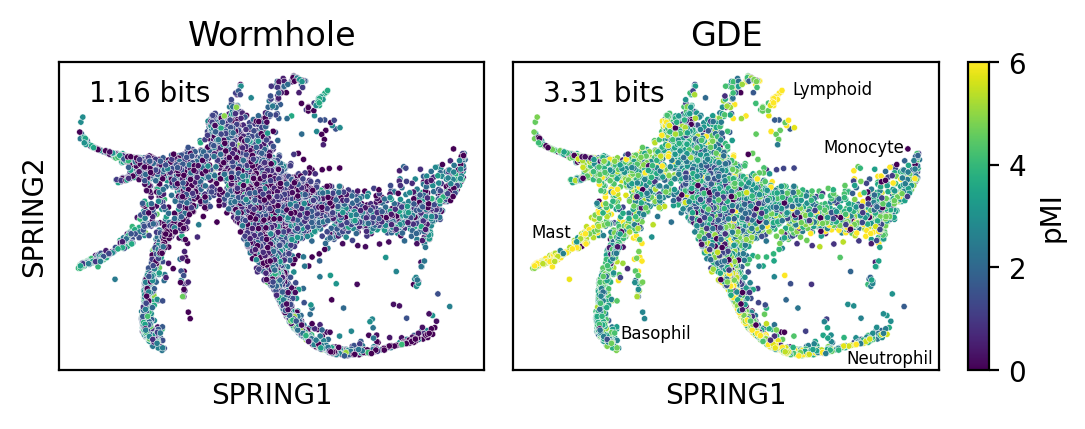

In [32]:
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# normalize hue values
norm = Normalize(vmin=0, vmax=6)
cmap = plt.cm.viridis

fig = plt.figure(figsize=(6, 2), dpi=200)
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.1)

# subplot 1
ax0 = plt.subplot(gs[0])
sns.scatterplot(
    data=cells[cells['time'] == 'early'],
    x='SPRING1', y='SPRING2', hue='pmi_cfg1', s=5,
    palette='viridis', hue_norm=(0,6), ax=ax0, legend=False
)
ax0.set_title('cfg0')

# subplot 2
ax1 = plt.subplot(gs[1])
sns.scatterplot(
    data=cells[cells['time'] == 'early'],
    x='SPRING1', y='SPRING2', hue='pmi_cfg0', s=5,
    palette='viridis', hue_norm=(0,6), ax=ax1, legend=False
)
ax1.set_title('GDE')
ax0.set_title('Wormhole')
ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel('')

ax1.text(-1800, 1300, f"%.2f bits" %(pmi_df['pmi_cfg0'].mean()))
ax0.text(-1800, 1300, f"%.2f bits" %(pmi_df['pmi_cfg1'].mean()))

ax1.text(2100, -2350, "Neutrophil", fontsize=6)
ax1.text(1800, 600, "Monocyte", fontsize=6)
ax1.text(1400, 1400, "Lymphoid", fontsize=6)
ax1.text(-800, -2000, "Basophil", fontsize=6)
ax1.text(-1950, -600, "Mast", fontsize=6)
# colorbar
cbar_ax = plt.subplot(gs[2])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label='pMI')

plt.tight_layout()
plt.show()